# Linear Discriminant Analysis (LDA)

ToDo: Linear Discriminant Analysis (https://machinelearningmastery.com/linear-discriminant-analysis-with-python/#:~:text=The%20hyperparameters%20for%20the%20Linear%20Discriminant%20Analysis%20method,values%20for%20solvers%20that%20support%20the%20shrinkage%20capability, https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

In [101]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_roc_curve

from sklearn.inspection import permutation_importance

In [45]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [46]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [47]:
# Create X matrix of regressor variables
X = df.drop(['DEATH_EVENT'], axis = 1)

In [48]:
# Create y vector of regressand variable DEATH_EVENT
y = df['DEATH_EVENT']

In [49]:
ratio_death = df[df["DEATH_EVENT"] == 1].DEATH_EVENT.sum() / df.DEATH_EVENT.count()
print(f"Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: {ratio_death}")

Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: 0.3210702341137124


In [50]:
# Hiobs Datengrundlage 

In [51]:
##split
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='time'), y , test_size=0.20, random_state=3)

##standardize (around 71% acc on val set)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)




### 1. Durchgang: Ursprüngliche Daten (standardisiert)

In [52]:
model = LinearDiscriminantAnalysis()

In [53]:
model.fit(X_train_sc, y_train)

LinearDiscriminantAnalysis()

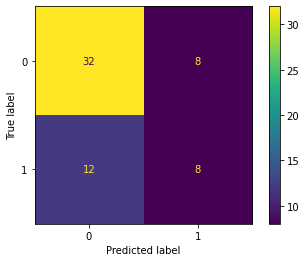

In [54]:
plot_confusion_matrix(model, X_test_sc, y_test);

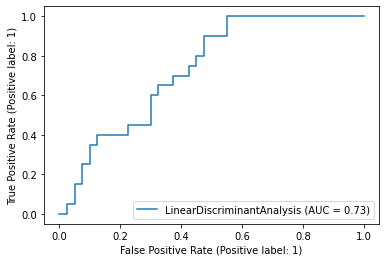

In [55]:
plot_roc_curve(model, X_test_sc, y_test);

### 2. Durchgang: SMOTE Upsampling Daten

In [56]:
#Experiment: SMOTE UPSAMLING

oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train_sc, y_train)

print(f"Neues Verhältnis nach SMOTE Anwendung:{y_train_sm[y_train_sm == 1].sum() / len(y_train_sm)}")


Neues Verhältnis nach SMOTE Anwendung:0.5


In [57]:
model_sm = LinearDiscriminantAnalysis()
model_sm.fit(X_train_sm, y_train_sm)

LinearDiscriminantAnalysis()

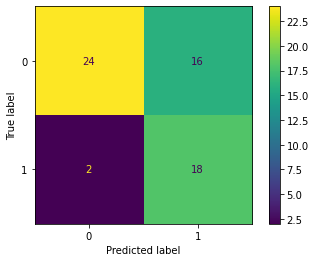

In [58]:
plot_confusion_matrix(model_sm, X_test_sc, y_test);

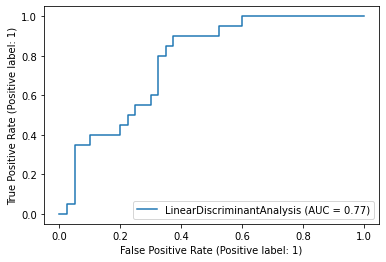

In [59]:
plot_roc_curve(model_sm, X_test_sc, y_test);

### 3. Durchgang: PCA Daten

In [60]:
pca = PCA(n_components=5)
X_train_pca = pd.DataFrame(data = pca.fit_transform(X_train_sc), columns=['pc1','pc2','pc3','pc4','pc5'])
X_test_pca = pd.DataFrame(data = pca.transform(X_test_sc), columns=['pc1','pc2','pc3','pc4','pc5'])

In [61]:
model_pca = LinearDiscriminantAnalysis()
model_pca.fit(X_train_pca, y_train)

LinearDiscriminantAnalysis()

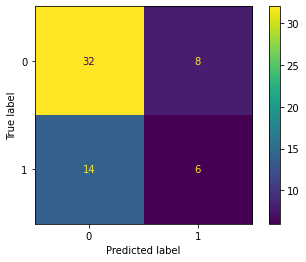

In [62]:
plot_confusion_matrix(model_pca, X_test_pca, y_test);

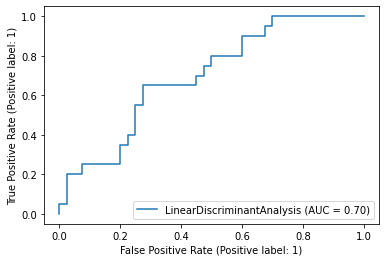

In [63]:
plot_roc_curve(model_pca, X_test_pca, y_test);

### 4. Durchgang: Beste Datengrundlage und Hyperparameter Tuning

In [95]:
grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [0.05, 1, 0.05]
}


In [96]:
model_tune = LinearDiscriminantAnalysis()
model_tune = GridSearchCV(model_tune, grid, cv=4, scoring = "roc_auc")
model_tune.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=4, estimator=LinearDiscriminantAnalysis(),
             param_grid={'shrinkage': [0.05, 1, 0.05],
                         'solver': ['lsqr', 'eigen']},
             scoring='roc_auc')

In [97]:
print(model_tune.best_params_)
print(model_tune.best_estimator_)

{'shrinkage': 1, 'solver': 'lsqr'}
LinearDiscriminantAnalysis(shrinkage=1, solver='lsqr')


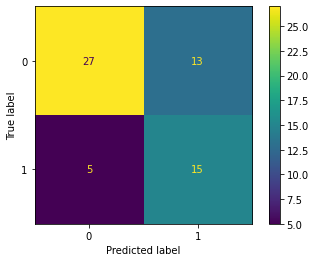

In [98]:
plot_confusion_matrix(model_tune, X_test_sc, y_test);

### Final Evaluation using ROC-AUC Curve & Score

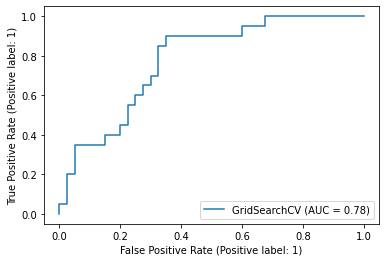

In [99]:
plot_roc_curve(model_tune, X_test_sc, y_test);

In [100]:
# Interpretation Hyperparameter LDA: https://scikit-learn.org/stable/modules/lda_qda.html

age, Score: 0.0572
anaemia, Score: 0.02
creatinine_phosphokinase, Score: -0.0078
diabetes, Score: 0.0007
ejection_fraction, Score: 0.1032
high_blood_pressure, Score: 0.008
platelets, Score: -0.001
serum_creatinine, Score: 0.0645
serum_sodium, Score: -0.0075
sex, Score: 0.0057
smoking, Score: 0.0025


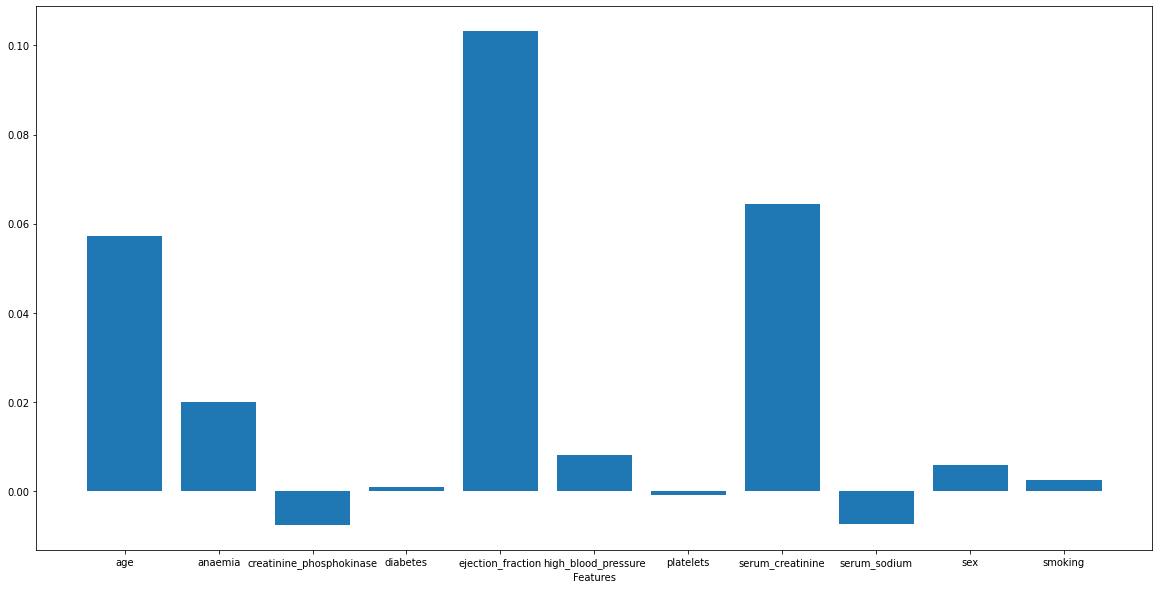

In [134]:
#ToDo: Feature Importance: 

plt.figure(figsize=(20,10))

# perform permutation importance
results = permutation_importance(model_tune, X_test_sc, y_test, scoring='roc_auc')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print(f'{X_test.columns[i]}, Score: {np.round(v, decimals=4)}')
# plot feature importance
plt.bar(X_test.columns, importance)
plt.xlabel("Features")
plt.show()